# Google Summer of Code project

# Developping a module for Approximate Bayesian Computation for PyMC3
Student: _Agustina Arroyuelo_ 

Mentors: _Junpeng Lao_, _Osvaldo Martin_

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
plt.style.use('bmh')

/home/agustina/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# What is ABC?

Approximate bayesian computation is a class of computational methods, also called Likelihood free inference methods, that _bypass_ the evaluation of the likelihood function.(Sunnaker, 2013).


# Why do we need Approximate Bayesian Computation or Likelihood Free Inference?

We need ABC because for some models the likelihood function is very complex and it's evaluation can be computationally costly. These models are typically called _simulator based model_. ABC is key in parameterizing simulator based models.

# What are Simulator Based Models? $M(\theta, V) = y$

* The likelihood function cannot be computed or is intractable due to their stochastic nature
* Typically have multiple parameters
* Given a set of parameters, it is 'easy' to generate data from them

# The most simple ABC algorithm is rejection ABC

In [2]:
# rejection ABC sampling
def rejection_abc(model=None, samples=1000, ϵ=0.5, plot=True):
    """
    Rejection ABC sampling 
    
    Parameters
    ----------
    model: pymc3 model
    samples : int
      Number of sampling steps
    ϵ : int or float
      Threshold value
      
    Returns
    -------
    accepted : list
      List of accepted θ
    """    
    
    model = pm.modelcontext(model)
    prior = model.unobserved_RVs[0]
    data = model.observed_RVs[0].observations
    size = len(data) 
    scale = data.std()
    mean = data.mean()
    accepted = []
    ys = []
    
    for _ in range(samples): 
        θ = prior.random() # prior sample
        y_θ = np.random.normal(loc=θ, scale=scale, size=size) # simulator
        ys.append(y_θ)
        if np.absolute(mean - y_θ.mean()) < ϵ: # distance function, summary statistic
            accepted.append(θ)
    
    if plot:
        _, ax = plt.subplots(1, 2, figsize=(12, 4))
        az.kdeplot(data, label='data', ax=ax[0])
        az.kdeplot(accepted, label='posterior', c='C7', ax=ax[1])
        [ax[i].scatter(accepted, [0]*len(accepted), marker='|', label='θ', c='C4') for i in range(len(ax))]
        [ax[i].legend() for i in range(len(ax))]
        [ax[i].set_yticks([]) for i in range(len(ax))]

    return accepted, ys

In [3]:
data = np.random.randn(1000)
with pm.Model() as model:
    a = pm.Normal('a')
    l = pm.Normal('l', observed=data)

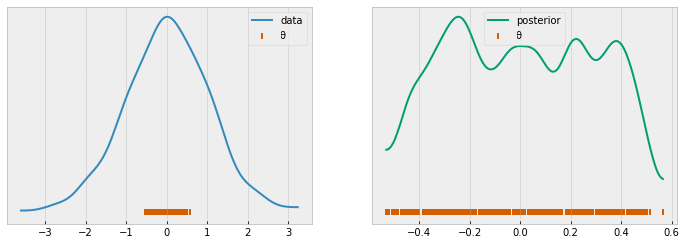

In [4]:
rej_abc = rejection_abc(model=model)

# For likelihood free inference we need...
 
* A simulator based model
* To choose a Summary statistic or a vector of them
* A threshold
* A distance function

# SMC - ABC is a bit more complex...

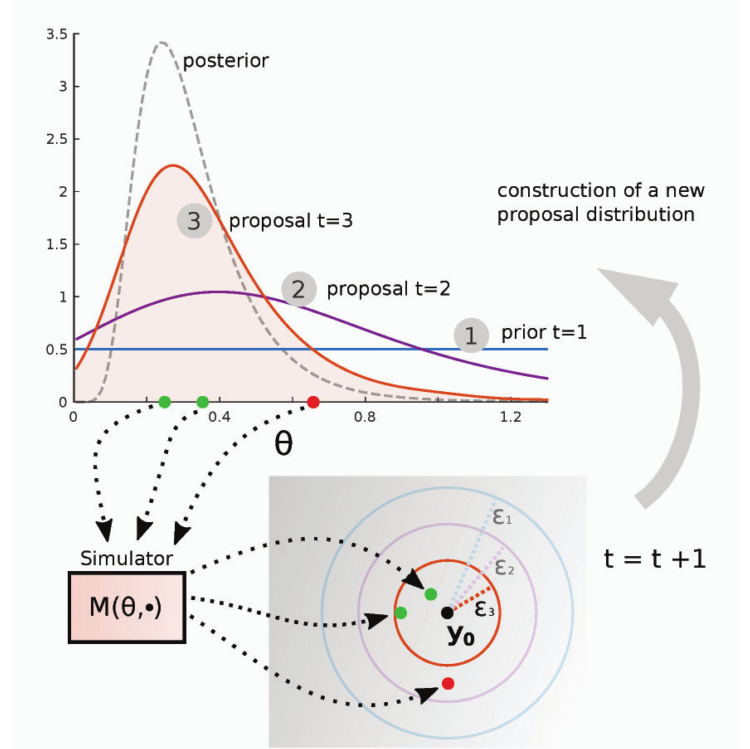
_(Lintusaari, 2016)_

1- $\theta$'s are drawn from the prior, if it is the first stage, or proposal distribution if it is not. 

2- They are _passed_ to the simulator model.

3- The output $y$ from the simulator are compared with the true data $y_0$ using a distance $d$ function and a threshold $\epsilon$.

4- The accepted parameters are weighted accoding to $$w^{(i)}  \alpha  \frac{p(\theta^{(i)})}{\phi(\theta^{(i)})}$$ with $\phi$ being the proposal distribution. 

_The weight of $\theta$ is proportional to the density of $\theta$ in the prior over the density of $\theta$ in the proposal distribution_

5- Return to 1-, $\epsilon$ decreases.

# Towards the implementation of an ABC module in PyMC3...

* ### Conceptually SMC-ABC is similar to the current implementation of SMC were every  step is a rejection ABC instead of MCMC.

* ### Simulator will be a variable inside a PyMC3 model, similar to pm.Deterministic variable, that takes parameters $\theta$, a distance function and a function that simulates data. 

* ### Simulator objects will _tell_ the sampler if the parameters were accepted or not accepted.

In [5]:
pm.Simulator('name', function=F(), distance='weighted Euclidean', observed=data, epsilon=5, params=[α, β, γ], sum_stat='')

AttributeError: module 'pymc3' has no attribute 'Simulator'

* # Thresholds are typically determined by simulating a pool of $(y, \theta)$ pairs and setting $\epsilon$ in a quantile of this distribution, for example 1%.
_(Beaumont, 2002)_

In [ ]:
# ys is a pool of simulated data
_, ys = rejection_abc(model=model, samples=50000, plot=False)

In [ ]:
from scipy.stats.mstats import mquantiles
threshold = mquantiles(ys, prob=[0.99])[0]

In [ ]:
reject_abc, ys = rejection_abc(model=model, samples=500, ϵ=threshold)

### Thresholds usually decrease like $N^{-1/4}$ or $N^{-1/(d+5)}$ where d is the dimension of the parameter space and N the number of accepted samples. 

In [ ]:
plt.plot([i**(-1/4) for i in range(1,100)], label='$N^{-1/4}$')
plt.plot([i**(-1/(1+5)) for i in range(1,100)], label='$N^{-1/(d+5)}$') # for one-dimensional data
plt.xlabel('Accepted samples')
plt.ylabel('$ϵ$')
plt.legend(); 

# Weights 
$$w^{(i)}  \alpha  \frac{p(\theta^{(i)})}{\phi(\theta^{(i)})}$$

# Distance functions
The user should be able to choose from a set of distance functions. [Interesting blog post about distance metrics](https://numerics.mathdotnet.com/distance.html)


## Summary statistics
* Curse of dimensionality
* Local informative summary statistics and global ones, are different.

[ABC (R package)](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00179.x), [PyABC](https://academic.oup.com/bioinformatics/advance-article-abstract/doi/10.1093/bioinformatics/bty361/4995841)


| $$SMC$$       | $$SMC-ABC$$           |
| --------- |:-------------:|
| Both methods compute the proposal's |covariance from the previous step|
| $$w^{(i)}  =  f(D|M,\theta)^{\beta_1 - \beta_0}$$  |$$w^{(i)}  \alpha  \frac{p(\theta^{(i)})}{\phi(\theta^{(i)})}$$|
|$$\beta$$|$$\epsilon$$|
|$$Likelihood$$|$$Simulator$$|

# Ending remarks
* In this Google Summer of Code project we will use and refactor the current implementation of SMC, to add the necessary components for an SMC-ABC module.
* We will include a new variable for PyMC models, called simulator. It will store the sequence of thresholds and distance functions, and comunicate the accepted parameters
* We are going to explore different methods for the choices of thresholds, distances and summary statistics, trying to base our decissions in existing implementations.